In [1]:
import struct
import datetime as dt
import glob
import os
from collections import namedtuple
import matplotlib.image as mpimg
import cv2

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# import pykitti.utils as utils

In [2]:
# fileName = '/Users/GF/Downloads/data_road_velodyne/testing/velodyne/um_000000.bin'
# with open(fileName, mode='rb') as file: # b is important -> binary
#     fileContent = file.read()
# struct.unpack("iiiii", fileContent[:20])

In [3]:
    def get_velo_scans(bin_path):
        obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
        return obj
    
#     def get_velo_scans(velo_file):
#         """read velodyne [x,y,z,reflectance] scan data from binary files."""
#         """parse velodyne binary files into arrays."""
#         scan = np.fromfile(velo_file, dtype='float32').reshape((-1, 4))
#         return scan

# def velo(data_path):
#         """Generator to read velodyne [x,y,z,reflectance] scan data from binary files."""
#         # Find all the Velodyne files
#         velo_path = os.path.join(
#             data_path, 'velodyne_points', 'data', '*.bin')
#         velo_files = sorted(glob.glob(velo_path))

#         # Subselect the chosen range of frames, if any
# #         if self.frames is not None:
# #             velo_files = [velo_files[i] for i in self.frames]

#         # Return a vgenerator yielding Velodyne scans.
#         # Each scan is a Nx4 array of [x,y,z,reflectance]
#         return get_velo_scans(velo_files)

In [4]:
    """Read in a calibration file and parse into a dictionary."""
    def read_calib_file(filepath):
        data = {}

        with open(filepath, 'r') as f:
            for line in f.readlines():
                key, value = line.split(':', 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data
    
    """
      Filter camera angles for KiTTI Datasets
    """
    def filter_by_camera_angle(pc):
        bool_in = np.logical_and((pc[:, 1] < pc[:, 0] - 0.27), (-pc[:, 1] < pc[:, 0] - 0.27))
        """
        /*
         * @brief KiTTI Velodyne Coordinate
         *          |x(forward)
         *      C   |   D
         *          |
         *  y---------------
         *          |
         *      B   |   A
         */
        """
        # bool_in = np.where(pc[:, 0] > 0)
        return pc[bool_in]

In [60]:
# filename = '/Users/GF/Downloads/data_road_velodyne-2/training/velodyne/um_000000.bin'
filename = '/Users/GF/Desktop/2011_09_26_drive_0002_sync/velodyne_points/data/0000000000.bin'
pc = get_velo_scans(filename)
print(pc.shape)
pc = filter_by_camera_angle(pc)
print(pc.shape)
# scan = np.fromfile(filename, dtype='uint8')
# cv2.imwrite('scan.png', scan[:640000].reshape(64,10000))
min(pc[2])

(121080, 4)
(29541, 4)


0.0

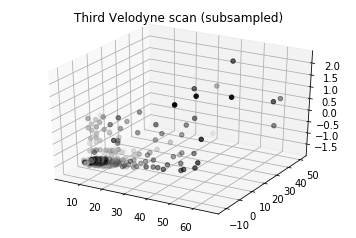

In [6]:
f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, pc.shape[0], 100)
ax2.scatter(pc[velo_range, 0],
            pc[velo_range, 1],
            pc[velo_range, 2],
            c=pc[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()

In [230]:
from matplotlib import cm

class Color(object):
    jet = None

    """
      https://github.com/ros-visualization/rviz/blob/kinetic-devel/src/rviz/default_plugin/point_cloud_transformers.cpp
      :return
        Rainbow color (rgb8) from val in [0., 1.]
    """
    @staticmethod
    def get_rainbow_color(val, min_val=0., diff=255):
        value = 1.0 - (val - min_val)
        # restrict value between 0 and 1
        value = max(value, 0.)
        value = min(value, 1.)

        h = value * 5.0 + 1.0
        i = int(h)
        f = h - i
        # if i is even
        if not i&1:
            f = 1 - f
        n = int((1 - f)*diff)
        bgr = [0]*3
        if i <= 1:
            bgr[2] = n; bgr[1] = 0; bgr[0] = 255
        elif i == 2:
            bgr[2] = 0; bgr[1] = n; bgr[0] = 255
        elif i == 3:
            bgr[2] = 0; bgr[1] = 255; bgr[0] = n
        elif i == 4:
            bgr[2] = n; bgr[1] = 255; bgr[0] = 0
        elif i >= 5:
            bgr[2] = 255; bgr[1] = n; bgr[0] = 0
        # print bgr
        return bgr


    def get_heat_color(point):
        
        rgb = [0]*3
#         if point[2] <= -1.7:
#             bgr[2] = 255; bgr[1] = 0; bgr[0] = 0
#         elif  point[2] <= -1.67 and point[2] > -1.7:
#             bgr[2] = 255; bgr[1] = 105; bgr[0] = 0
#         elif  point[2] <= -1.64 and point[2] > -1.67:
#             bgr[2] = 255; bgr[1] = 200; bgr[0] = 0
        if point[2] <= -1.67:
            rgb[2] = 255; rgb[1] = 150-(point[2]/-2)*150; rgb[0] = 0
        
        elif  point[2] <= -1.63 and point[2] > -1.67:
            rgb[2] = 255; rgb[1] = 125; rgb[0] = 0
        elif  point[2] <= -1.6 and point[2] > -1.63:
            rgb[2] = 255; rgb[1] = 200; rgb[0] = 0
        elif  point[2] <= -1.55 and point[2] > -1.6:
            rgb[2] = 255; rgb[1] = 255; rgb[0] = 0
        elif  point[2] <= -1.4 and point[2] > -1.55:
            rgb[2] = 0; rgb[1] = 255; rgb[0] = 0
        elif  point[2] <= -1.2 and point[2] > -1.4:
            rgb[2] = 0; rgb[1] = 255; rgb[0] = 125
        elif  point[2] <= 0 and point[2] > -1.2:
            rgb[2] = 0; rgb[1] = 75; rgb[0] = 255
        else:
            rgb[2] = 0; rgb[1] = 0; rgb[0] = 255
            
        return rgb
        
    

In [136]:
# for p in pc:
#     print(p[3])
# height = pc[:,2]
# max(height)

2.9059999

In [227]:
    """
      1. Color Point Cloud from RGB Image
      2. Project Point Cloud into RGB Image for depth
      3. Also apply to Gray Image
    """
    def lidar_camera_fusion(point_cloud, image, T_velo_cam, P_velo_image):
        image_size = image.shape

        is_gray = len(image_size) < 3
        if is_gray:
            print("LiDAR Gray-Image fusing...")
        else:
            print("LiDAR RGB-Image fusing...")

        image_depth = image.copy()

        # XYZRGB point cloud
        pc_rgb = np.zeros((point_cloud.shape[0], 4), dtype=np.float32)
        pc_rgb[:, :3] = point_cloud[:, :3]

        xyz = point_cloud.copy()
        xyz[:,3] = 1.0
        # project into image
        velo_img = np.dot(P_velo_image, xyz.T).T
        # normalize homogeneous coordinates
        velo_img = np.true_divide(velo_img[:,:2], velo_img[:,[-1]])
        velo_img = np.round(velo_img).astype(np.uint16)

        # compute depth in Camera coordinate
#         pc_img = np.dot(T_velo_cam, xyz.T).T
#         depth = np.sqrt(np.square(pc_img[:, 0]) + np.square(pc_img[:, 1]) + np.square(pc_img[:, 2]))
#         depth_min = min(depth)
#         depth_max = max(depth)
#         depth = depth / (depth_max - depth_min)

        height = point_cloud[:,2]
        height_min = min(height)
        height_max = min(height)
        height = height / height_max
        

        if is_gray:
            for pt in range(0, velo_img.shape[0]):
                row_idx = velo_img[pt][1]
                col_idx = velo_img[pt][0]

                if (row_idx >= 0 and row_idx < image_size[0]) \
                        and (col_idx >= 0 and col_idx < image_size[1]):
                    # assign image color to point cloud
                    color =   (image[row_idx][col_idx] << 16) \
                            | (image[row_idx][col_idx] << 8) \
                            | image[row_idx][col_idx]
                    pc_rgb[pt, 3] = color

                    # assign point cloud to image pixel
                    cv2.circle(image_depth, (col_idx,row_idx), 1, depth[pt] * 255, thickness=-1)
        else:
            for pt in range(0, velo_img.shape[0]):
                row_idx = velo_img[pt][1]
                col_idx = velo_img[pt][0]

                if (row_idx >= 0 and row_idx < image_size[0]) \
                        and (col_idx >= 0 and col_idx < image_size[1]):
                    # assign image color to point cloud
#                     color =   (image[row_idx][col_idx][2] << 16) \
#                               | (image[row_idx][col_idx][1] << 8) \
#                               | image[row_idx][col_idx][0]
                    color = image[row_idx][col_idx][2]
                    pc_rgb[pt, 3] = color

                    # assign point cloud to image pixel
                    # use rainbow color band
                    cv_color = Color.get_heat_color(point_cloud[pt])
#                     cv_color = Color.get_rainbow_color(height[pt])
                    # image_depth[row_idx][col_idx] = cv_color
                    cv2.circle(image_depth, (col_idx,row_idx), 1, cv_color, thickness=-1)

        return pc_rgb, image_depth

In [231]:
    """
      RAW_DATASET
    """     
    calib_cam_to_cam_file =  "/Users/GF/Desktop/2011_09_26/calib_cam_to_cam.txt"
    calib_velo_to_cam_file = "/Users/GF/Desktop/2011_09_26/calib_velo_to_cam.txt"
    calib_imu_to_velo_file = "/Users/GF/Desktop/2011_09_26/calib_imu_to_velo.txt"
    
    calib_cam2cam = read_calib_file(calib_cam_to_cam_file)
    # To project a 3D point x in reference camera coordinates to a point y on the i'th image plane,
    # the rectifying rotation matrix of the reference camera: R_rect_00 must be considered as well.
    R_rect_00 = np.zeros((4, 4))
    R_rect_00[:3,:3] = np.array(calib_cam2cam['R_rect_00']).reshape(-1, 3)
    R_rect_00[3,3] = 1.
    print("     ----------- R_rect_00 -----------")
    print (R_rect_00)
    # To project to a point in the i'th camera image, 0...3
    P_rect_02 = np.zeros((3, 4))
    P_rect_02 = np.array(calib_cam2cam['P_rect_02']).reshape(-1, 4)
    print("     ----------- P_rect_02 -----------")
    print (P_rect_02)

    calib_velo2cam = read_calib_file(calib_velo_to_cam_file)
    vel2cam0 = np.zeros((4, 4))
    vel2cam0[:3,:3] = np.array(calib_velo2cam['R']).reshape(-1, 3)
    vel2cam0[:3,3] = calib_velo2cam['T']
    vel2cam0[3,3] = 1.
    print("     ----------- T_velo_cam -----------")
    print (vel2cam0)

    # compute transform matrix
    T_velo_to_cam = np.dot(R_rect_00, vel2cam0)
    print("     ----------- T_velo_cam -----------")
    print (T_velo_to_cam)
    print("\n\n")
    # P_velo_to_img = np.dot(P_rect_02, T_velo_to_cam)
    P_velo_to_img = np.dot(P_rect_02, np.dot(R_rect_00, vel2cam0))
    print("     ----------- P_velo_image -----------")
    print (P_velo_to_img)
    print("\n\n")
    
    img_path = '/Users/GF/Desktop/2011_09_26_drive_0002_sync/image_02/data/0000000000.png'
    image = cv2.imread(img_path)

    # XYZRGB point cloud and depth image
    pc_rgb, image_depth = lidar_camera_fusion(pc, image, T_velo_to_cam, P_velo_to_img)
    
    cv2.imwrite('/Users/GF/Desktop/pc_rgb.png', pc_rgb)
    cv2.imwrite('/Users/GF/Desktop/image_depth.png', image_depth)
    print('Done')

     ----------- R_rect_00 -----------
[[ 0.9999239   0.00983776 -0.00744505  0.        ]
 [-0.0098698   0.9999421  -0.00427846  0.        ]
 [ 0.00740253  0.00435161  0.9999631   0.        ]
 [ 0.          0.          0.          1.        ]]
     ----------- P_rect_02 -----------
[[  7.21537700e+02   0.00000000e+00   6.09559300e+02   4.48572800e+01]
 [  0.00000000e+00   7.21537700e+02   1.72854000e+02   2.16379100e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.74588400e-03]]
     ----------- T_velo_cam -----------
[[  7.53374500e-03  -9.99971400e-01  -6.16602000e-04  -4.06976600e-03]
 [  1.48024900e-02   7.28073300e-04  -9.99890200e-01  -7.63161800e-02]
 [  9.99862100e-01   7.52379000e-03   1.48075500e-02  -2.71780600e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
     ----------- T_velo_cam -----------
[[  2.34773698e-04  -9.99944155e-01  -1.05634778e-02  -2.79681694e-03]
 [  1.04494074e-02   1.05653536e-02  -9.99889574e-01  -7.51087914e-

In [92]:
pc.shape

(29541, 4)

In [232]:
    """
      ROAD_DATASET
    """  

    img_path = '/Users/GF/Desktop/data_road/training/image_2/um_000000.png'
    image_road = cv2.imread(img_path)
    
    # filename = '/Users/GF/Downloads/data_road_velodyne-2/training/velodyne/um_000000.bin'
    filename = '/Users/GF/Desktop/data_road_velodyne/training/velodyne/um_000000.bin'
    pc_road = get_velo_scans(filename)
    pc_road = filter_by_camera_angle(pc_road)
    print(pc_road.shape)
    print(pc.shape)

    # Camera angle filters
#     pc = filter_by_camera_angle(pc)
#     print('point_cloud p_num: ',pc.shape)
    # XYZRGB point cloud and depth image
    pc_rgb_r, image_depth_r = lidar_camera_fusion(pc_road, image_road, T_velo_to_cam, P_velo_to_img)
    
    cv2.imwrite('/Users/GF/Desktop/pc_rgb_r.png', pc_rgb_r)
    cv2.imwrite('/Users/GF/Desktop/image_depth_r.png', image_depth_r)
    print('Done')

(29553, 4)
(29541, 4)
LiDAR RGB-Image fusing...
Done


In [41]:
pc

array([[ 51.5870018 ,   0.103     ,   1.954     ,   0.        ],
       [ 51.24499893,   0.183     ,   1.94200003,   0.        ],
       [ 51.25999832,   0.34400001,   1.94200003,   0.        ],
       ..., 
       [  3.704     ,  -1.40100002,  -1.73099995,   0.31999999],
       [  3.73699999,  -1.39999998,  -1.745     ,   0.41999999],
       [  3.74699998,  -1.38999999,  -1.74800003,   0.        ]], dtype=float32)

In [242]:
def img_lidar_fusion(img_dir, lid_dir, o_dir):
    
    calib_cam_to_cam_file =  "/Users/GF/Desktop/2011_09_26/calib_cam_to_cam.txt"
    calib_velo_to_cam_file = "/Users/GF/Desktop/2011_09_26/calib_velo_to_cam.txt"
    calib_imu_to_velo_file = "/Users/GF/Desktop/2011_09_26/calib_imu_to_velo.txt"
    
    calib_cam2cam = read_calib_file(calib_cam_to_cam_file)
    # To project a 3D point x in reference camera coordinates to a point y on the i'th image plane,
    # the rectifying rotation matrix of the reference camera: R_rect_00 must be considered as well.
    R_rect_00 = np.zeros((4, 4))
    R_rect_00[:3,:3] = np.array(calib_cam2cam['R_rect_00']).reshape(-1, 3)
    R_rect_00[3,3] = 1.

    # To project to a point in the i'th camera image, 0...3
    P_rect_02 = np.zeros((3, 4))
    P_rect_02 = np.array(calib_cam2cam['P_rect_02']).reshape(-1, 4)


    calib_velo2cam = read_calib_file(calib_velo_to_cam_file)
    vel2cam0 = np.zeros((4, 4))
    vel2cam0[:3,:3] = np.array(calib_velo2cam['R']).reshape(-1, 3)
    vel2cam0[:3,3] = calib_velo2cam['T']
    vel2cam0[3,3] = 1.

    os.chdir(img_dir)
    all_img = glob.glob('*.png')
    all_img.sort()
    os.chdir(lid_dir)
    all_lid = glob.glob('*.bin')
    all_lid.sort
    # compute transform matrix
    T_velo_to_cam = np.dot(R_rect_00, vel2cam0)

    # P_velo_to_img = np.dot(P_rect_02, T_velo_to_cam)
    P_velo_to_img = np.dot(P_rect_02, np.dot(R_rect_00, vel2cam0))


    for i in range(len(all_img)):
        print(all_img[i])
        print(all_lid[i])
        image = cv2.imread(img_dir + all_img[i])
        point_cloud = get_velo_scans(lid_dir + all_lid[i])
        point_cloud = filter_by_camera_angle(point_cloud)
        pc_rgb, image_depth = lidar_camera_fusion(point_cloud, image, T_velo_to_cam, P_velo_to_img)

        cv2.imwrite(o_dir + 'fusion_' + str(i) + '.png', image_depth)
        
    print('Done')
        

In [244]:
img_dir = '/Users/GF/Desktop/data_road/training/image_2/'
lid_dir = '/Users/GF/Desktop/data_road_velodyne/training/velodyne/'
o_dir = '/Users/GF/Desktop/fuse_data_road/'

img_lidar_fusion(img_dir, lid_dir, o_dir)

um_000000.png
um_000000.bin
LiDAR RGB-Image fusing...
um_000001.png
um_000001.bin
LiDAR RGB-Image fusing...
um_000002.png
um_000002.bin
LiDAR RGB-Image fusing...
um_000003.png
um_000003.bin
LiDAR RGB-Image fusing...
um_000004.png
um_000004.bin
LiDAR RGB-Image fusing...
um_000005.png
um_000005.bin
LiDAR RGB-Image fusing...
um_000006.png
um_000006.bin
LiDAR RGB-Image fusing...
um_000007.png
um_000007.bin
LiDAR RGB-Image fusing...
um_000008.png
um_000008.bin
LiDAR RGB-Image fusing...
um_000009.png
um_000009.bin
LiDAR RGB-Image fusing...
um_000010.png
um_000010.bin
LiDAR RGB-Image fusing...
um_000011.png
um_000011.bin
LiDAR RGB-Image fusing...
um_000012.png
um_000012.bin
LiDAR RGB-Image fusing...
um_000013.png
um_000013.bin
LiDAR RGB-Image fusing...
um_000014.png
um_000014.bin
LiDAR RGB-Image fusing...
um_000015.png
um_000015.bin
LiDAR RGB-Image fusing...
um_000016.png
um_000016.bin
LiDAR RGB-Image fusing...
um_000017.png
um_000017.bin
LiDAR RGB-Image fusing...
um_000018.png
um_000018.bin


umm_000055.png
umm_000055.bin
LiDAR RGB-Image fusing...
umm_000056.png
umm_000056.bin
LiDAR RGB-Image fusing...
umm_000057.png
umm_000057.bin
LiDAR RGB-Image fusing...
umm_000058.png
umm_000058.bin
LiDAR RGB-Image fusing...
umm_000059.png
umm_000059.bin
LiDAR RGB-Image fusing...
umm_000060.png
umm_000060.bin
LiDAR RGB-Image fusing...
umm_000061.png
umm_000061.bin
LiDAR RGB-Image fusing...
umm_000062.png
umm_000062.bin
LiDAR RGB-Image fusing...
umm_000063.png
umm_000063.bin
LiDAR RGB-Image fusing...
umm_000064.png
umm_000064.bin
LiDAR RGB-Image fusing...
umm_000065.png
umm_000065.bin
LiDAR RGB-Image fusing...
umm_000066.png
umm_000066.bin
LiDAR RGB-Image fusing...
umm_000067.png
umm_000067.bin
LiDAR RGB-Image fusing...
umm_000068.png
umm_000068.bin
LiDAR RGB-Image fusing...
umm_000069.png
umm_000069.bin
LiDAR RGB-Image fusing...
umm_000070.png
umm_000070.bin
LiDAR RGB-Image fusing...
umm_000071.png
umm_000071.bin
LiDAR RGB-Image fusing...
umm_000072.png
umm_000072.bin
LiDAR RGB-Image fu